In [30]:
from inseq import load_model
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import pandas as pd
# Load model with gradient-based attribution
# there is: gpt2, gpt2-medium, gpt2-large, gpt2-xl
model = load_model(model="gpt2", attribution_method="saliency", device="cuda" if torch.cuda.is_available() else "cpu")
embedding_layer = model.model.get_input_embeddings()


c:\Users\Kalai\anaconda3\envs\XAI\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


# Various Plots / Analysis of the Embedding Space

## Histogram Plot

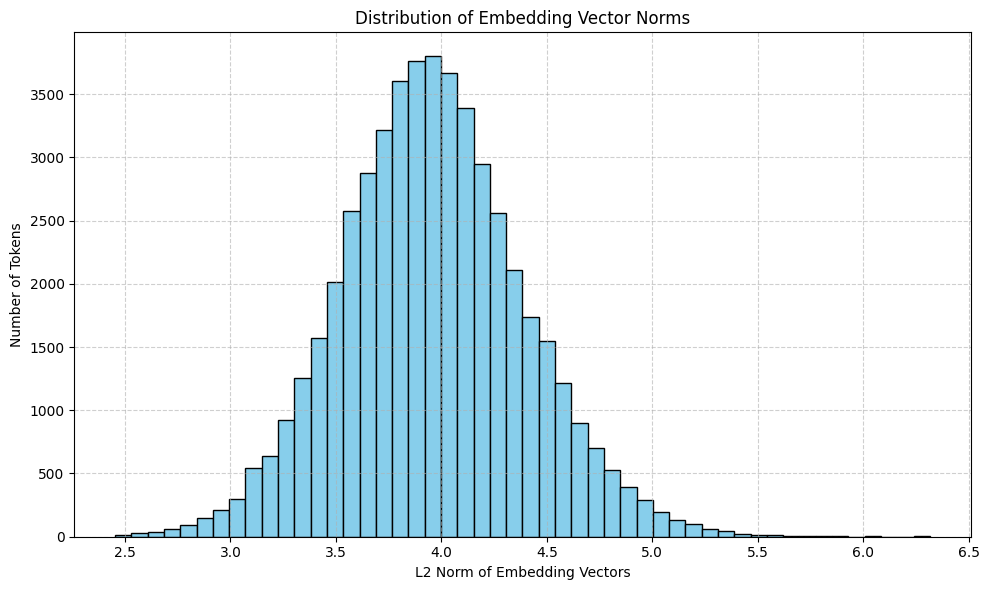

In [ ]:
# plot histogram
import torch
import matplotlib.pyplot as plt

def plot_embedding_norm_histogram(embedding_layer, bins=50):
    """
    Plot a histogram of vector norms from the embedding layer.

    Args:
        embedding_layer (torch.nn.Embedding): The embedding layer of the model.
        bins (int): Number of histogram bins.
    """

    # Get all token embeddings
    embeddings = embedding_layer.weight.detach().cpu()  # shape: [vocab_size, embedding_dim]

    # Compute L2 norms for each embedding vector
    norms = torch.norm(embeddings, p=2, dim=1).numpy()  # shape: [vocab_size]

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(norms, bins=bins, color='skyblue', edgecolor='black')
    plt.title("Distribution of Embedding Vector Norms")
    plt.xlabel("L2 Norm of Embedding Vectors")
    plt.ylabel("Number of Tokens")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_embedding_norm_histogram(embedding_layer=embedding_layer)

## Embedding Space Size

In [28]:
from transformers import GPT2Model, GPT2Tokenizer

# Load model and tokenizer
model = GPT2Model.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Access the embedding layer
embedding_layer = model.get_input_embeddings()

# Get size: (vocab_size, embedding_dim)
embedding_size = embedding_layer.weight.shape
print(f"Embedding matrix size: {embedding_size}")
print(f"Embedding dimension: {embedding_size[1]}")

Embedding matrix size: torch.Size([50257, 768])
Embedding dimension: 768


## Operation on Embedding Vectors

In [ ]:
# MANUAL CHECKING OF THINGS
sec_to_first =first_embed + second_embed # King + woman = queen ? 
res = sec_to_first[0][0].tolist()
res_norm  = sum(res)
res = [i / res_norm for i in res]

all_token_embeddins = embedding_layer.weight
check = all_token_embeddins[0] 
check_norm = check.abs().norm()

final_check = check / check_norm

all_token_embeddins_norm = all_token_embeddins / all_token_embeddins.norm(dim=1, keepdim=True)
all_token_embeddins_norm[0]

tensor([-3.5883e-02, -1.2797e-02,  1.0790e-02,  4.3615e-02, -1.5798e-02,
        -2.5720e-02, -7.8144e-02, -2.9160e-02,  8.2307e-03, -3.5001e-02,
        -5.9036e-02, -2.1886e-02,  2.4089e-02, -5.2573e-03,  3.8009e-03,
         4.0574e-02, -6.3976e-04, -2.6562e-02,  1.1008e-02,  7.7070e-02,
        -2.5125e-02, -1.1261e-02, -7.6285e-03, -3.0234e-02,  4.3552e-02,
        -2.1543e-02, -1.6352e-02,  1.5124e-02, -2.3128e-02, -2.9570e-02,
         1.3953e-02, -2.8770e-02,  3.1865e-02, -4.5021e-02, -4.5739e-02,
        -4.0947e-02, -1.0344e-01, -3.5575e-02, -2.3090e-02,  1.9035e-02,
         2.5741e-03, -9.6943e-03,  4.6608e-02,  1.0148e-02, -1.0194e-02,
         3.5905e-02,  1.7906e-02, -1.9204e-02,  1.1602e-02, -4.9946e-02,
         5.0537e-03,  2.3517e-02,  9.0339e-03,  2.4332e-02,  4.3815e-02,
        -3.9260e-02,  2.3941e-02,  4.3044e-02, -2.6448e-02,  2.9489e-02,
        -3.3099e-02, -1.0364e-02,  2.4694e-02, -8.5299e-03, -5.7928e-02,
         1.8264e-03, -8.9567e-03, -7.7509e-02,  5.7

In [ ]:
first_input = model.tokenizer("queen", return_tensors="pt")
first_embed = embedding_layer(first_input.input_ids)
second_input = model.tokenizer("king", return_tensors="pt")
second_embed = embedding_layer(second_input.input_ids)

sec_to_first =first_embed + second_embed # King + woman = queen ? 
sec_to_first[0][0].tolist()
norm_sec_to_first = sec_to_first / sec_to_first.norm()

all_token_embeddins = embedding_layer.weight
all_token_embeddins_norm = all_token_embeddins / all_token_embeddins.norm(dim=1, keepdim=True)

cosine_sim = torch.cosine_similarity(sec_to_first, all_token_embeddins)

top_k_indices = torch.topk(cosine_sim, 10).indices
print(top_k_indices.tolist())
top_k_tokens = model.tokenizer.convert_ids_to_tokens(top_k_indices.tolist()[0])
top_k_tokens



RuntimeError: The size of tensor a (2) must match the size of tensor b (50257) at non-singleton dimension 1

# Main Gradient Opitmisation Method

## Embedding Optimisation

In [14]:

def pre_process(target_token):
    
    target_token = model.tokenizer.tokenize(" " + target_token.strip()) # make sur the target output word starts with a space to ahve a recognised token
    if len(target_token) == 1: 
        target_token = target_token[0]
    else: 
        print(f"Several tokens have been assigned to the target output word: {target_token}.")
        return None
    target_id = model.tokenizer.convert_tokens_to_ids(target_token) # convert the target token to ID

    if target_id == model.tokenizer.unk_token_id:
        print(f"Warning: Target token '{target_token}' not found in vocabulary. Using UNK ID ({target_id}). Results might not be meaningful.")
        return None

    return target_token, target_id

def compute_grad(inputs, target_id):
    with torch.set_grad_enabled(True):
        # Get embeddings and mark as requiring gradients (so that we retain the gradient for non-leaf tensors)
        embeddings = embedding_layer(inputs.input_ids)
        embeddings.retain_grad()
        embeddings.requires_grad_(True)
    
        # Forward pass through model
        outputs = model.model(
            inputs_embeds=embeddings,
            attention_mask=inputs.attention_mask
        )
        # Get logits for the target position (next token prediction)
        # target_position = -1  # Position after last input token
        target_logit = outputs.logits[0, -1, target_id]
        
        # Compute gradients d(logit)/d(embeddings)
        target_logit.backward()
        gradients = embeddings.grad.clone()
    
    return embeddings, gradients, outputs

def get_new_token(modified_embeddings, token_input_position, inputs, distance_type): 
    # Nearest Neighbor Search
    all_embeddings = embedding_layer.weight #Vocab Embeddings; all tokens in vocabulary
    new_token_ids = []
    if distance_type == "cosine_similarity":
        distances = F.cosine_similarity(modified_embeddings[0][token_input_position], all_embeddings, dim=-1)
    elif distance_type == "dot_product": 
        distances = torch.matmul(all_embeddings, modified_embeddings[0][token_input_position])
    elif distance_type == "euclidean" : 
        distances = -torch.norm(all_embeddings - modified_embeddings[0][token_input_position], dim=1) # take "-" because it is a distance metric so smaller values mean better but it is the opposite for sim. metrics (cos. sim., dot. prod.)
    elif distance_type == "manhattan" : 
        distances = -torch.sum(torch.abs(all_embeddings - modified_embeddings[0][token_input_position]), dim=1)
    new_id = torch.argmax(distances).item()
    new_token_ids.append(new_id)
    inputs['input_ids'][0][token_input_position] = new_token_ids[0]
    new_token_ids = inputs['input_ids']

    new_token = model.tokenizer.convert_ids_to_tokens(new_id) # for plot

    #Decode the new tokens
    new_tokens = model.tokenizer.convert_ids_to_tokens(new_token_ids[0])
    new_text = model.tokenizer.convert_tokens_to_string(new_tokens)
    return new_token, new_tokens, new_text

def optimize_single_input_token_toward_target(input_text, target_token, step,
                                               n_iteration, token_input_position, distance_type="cosine_similarity", 
                                               random_dir = False, opposite_dir=True, grad=None) : 

    target_token, target_id = pre_process(target_token)
    original_text = input_text

    for i in range(n_iteration) :
        
        inputs = model.tokenizer(original_text, return_tensors="pt")
        embeddings, gradients, outputs = compute_grad(inputs, target_id)

        if grad == None: 
            for i in range(len(gradients[0])) : 
                gradients[0][i] = gradients[0][i] / (sum(abs(i) for i in gradients[0][i]))
        else: 
            gradients = grad
        
        # print("HERE GRADIENTS: ", gradients)
        if opposite_dir == True : 
            gradients *=-1

        elif random_dir == True: 
            random.shuffle(gradients[0][token_input_position]) # shuffle the gradient of the input token to optimise

        modified_embeddings = embeddings
        modified_embeddings[0][token_input_position] += gradients[0][token_input_position]*step + 0.9*(gradients[0].mean(dim=0))*step #consider the context (0.5*mean of the input embeddings)

        new_token, new_tokens, new_text = get_new_token(modified_embeddings, token_input_position, inputs, distance_type)
        
        # print(f"Original text: {original_text}")
        # print(f"Modified text: {new_text}")

        # Compare Probabilities
        with torch.no_grad():
            modified_outputs = model.model(
                inputs_embeds=modified_embeddings,
                attention_mask=inputs.attention_mask
            )
            original_probs = torch.softmax(outputs.logits[0, -1], dim=-1) # -1 corresponds to the target position: the last token, the token to be generated
            modified_probs = torch.softmax(modified_outputs.logits[0, -1], dim=-1)

        # print(f"Original probability of '{target_token}': {original_probs[target_id].item():.10f}")
        # print(f"Modified probability of '{target_token}': {modified_probs[target_id].item():.10f}")

        original_text = new_text

    return new_text, [modified_probs[target_id].item(), new_token], gradients


In [13]:

def get_plot_data(steps, input_text, input_token_pos,  target_token, random_dir=False, opposite_dir=False, compute_distance="cosin_similarity", explore_radius=False, gradient=None) :
    data_plot = {}
    for step in range(steps) : 
        if step%100==0:
              print("STEP: ", step)
        step  = 1 if explore_radius==True else step # Explore a radius of 1 around the initial embedding, take random directions
        if opposite_dir == True: 
                new_text, data_plot[step], gradients = optimize_single_input_token_toward_target(input_text=input_text, target_token=target_token, step=step, 
                                                                                                token_input_position=input_token_pos, n_iteration=1, opposite_dir=opposite_dir, 
                                                                                                distance_type=compute_distance, grad=gradient, random_dir=random_dir)
        else:
                new_text, data_plot[step], gradients = optimize_single_input_token_toward_target(input_text=input_text, target_token=target_token, step=step, 
                                                                                                token_input_position=input_token_pos, n_iteration=1, opposite_dir=opposite_dir, 
                                                                                             distance_type=compute_distance, grad=gradient, random_dir=random_dir)
    return new_text, data_plot, gradients

new_text, data_plot, gradients = get_plot_data(steps=500, input_text="Stop that fox from", input_token_pos = 2,
                                               target_token="barking", compute_distance="euclidean", opposite_dir=False)

STEP:  0


TypeError: can't multiply sequence by non-int of type 'float'

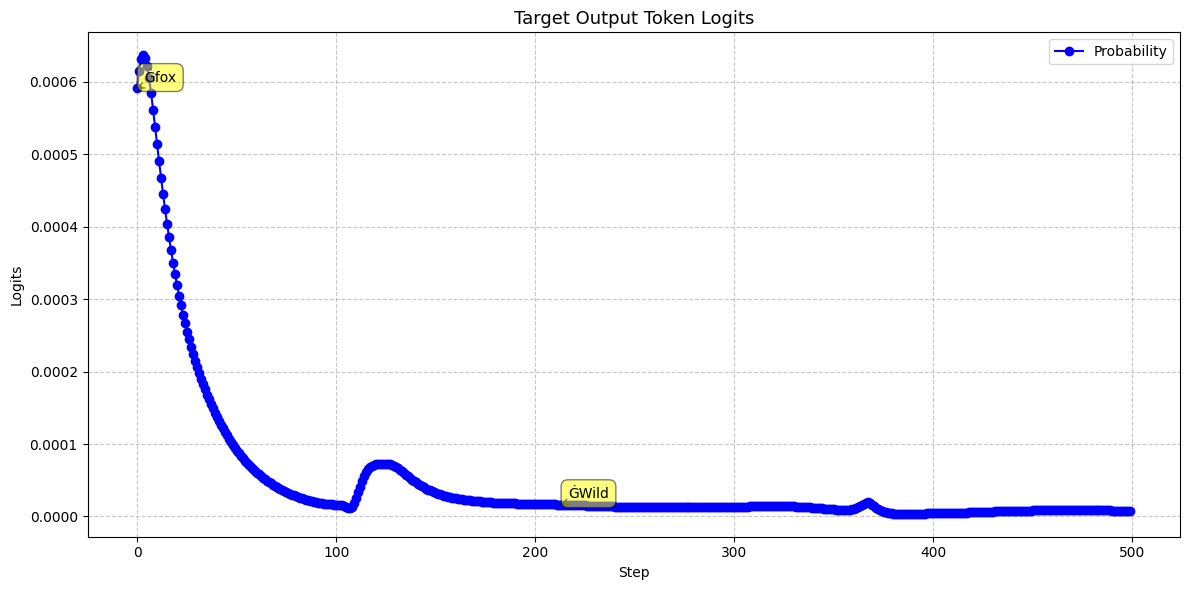

In [11]:
# PLOT
df = pd.DataFrame.from_dict(data_plot, orient='index', columns=["Probability", "Token"])
df.index.name = "Step"

plt.figure(figsize=(12,6))
line = plt.plot(df.index, df["Probability"], 
                marker='o', linestyle='-', color='b', label='Probability')

prev_token = None
for step, row in df.iterrows():
    current_token = row['Token']
    if current_token != prev_token : 
        plt.annotate(current_token, 
                     xy=(step, row["Probability"]), 
                     xytext=(5,5),
                     textcoords="offset points", 
                     bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5), 
                     arrowprops=dict(arrowstyle='->'))
        
    prev_token=current_token

plt.title("Target Output Token Logits", fontsize=13)
plt.xlabel("Step", fontsize=10)
plt.ylabel("Logits", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7), 
plt.legend()

plt.tight_layout()
plt.show()
        

In [ ]:
# Change input at each step (re-comput ethe gradient)
original_text = "Stop that dog from"
text = original_text
iterations = 1
results = []
data_plot = {}
while iterations < 501:
    if iterations%100==0: 
        print("STEP: ", iterations)
    iterations+=1
    if text != original_text: 
        print("NEW INPUT TEXT: ", text)
        iterations = 1
        original_text = text
    text, data_plot[(text, iterations)], gradients = optimize_single_input_token_toward_target(input_text=text, target_token="barking", step=iterations,
                                                                                               token_input_position=2, n_iteration=1, opposite_dir=False, 
                                                                                               distance_type="euclidean", grad=None, random_dir=False)

STEP:  100
STEP:  200
NEW INPUT TEXT:  Stop that birds from
STEP:  100
STEP:  200
STEP:  300
NEW INPUT TEXT:  Stop that wakes from
STEP:  100
STEP:  200
NEW INPUT TEXT:  Stop that awoke from
STEP:  100
STEP:  200
NEW INPUT TEXT:  Stop that waking from
STEP:  100
STEP:  200
NEW INPUT TEXT:  Stop that awoke from
STEP:  100
STEP:  200
NEW INPUT TEXT:  Stop that waking from
STEP:  100
STEP:  200
NEW INPUT TEXT:  Stop that awoke from
STEP:  100
STEP:  200
NEW INPUT TEXT:  Stop that waking from
STEP:  100
STEP:  200
NEW INPUT TEXT:  Stop that awoke from
STEP:  100
STEP:  200
NEW INPUT TEXT:  Stop that waking from
STEP:  100
STEP:  200
NEW INPUT TEXT:  Stop that awoke from
STEP:  100
STEP:  200
NEW INPUT TEXT:  Stop that waking from
STEP:  100
STEP:  200
NEW INPUT TEXT:  Stop that awoke from
STEP:  100
STEP:  200
NEW INPUT TEXT:  Stop that waking from
STEP:  100
STEP:  200
NEW INPUT TEXT:  Stop that awoke from
STEP:  100
STEP:  200
NEW INPUT TEXT:  Stop that waking from
STEP:  100


KeyboardInterrupt: 

## Value Vector Optimisation

**Comment**: When we modify a value vector (V) at a specific layer for a specific token position we are not directly or indirectly changing the original input embedding so there will not be new tokens.

The input token goes through the following steps: 
* Tokenization: the input text is broken into tokens
* Token IDs: each token is converted into a numerical ID
* Input Embedding: each input ID is used to look up a corresponding vector from the model embedding matrix where each row is the embedding vector for a unique token ID. This lookup happens once at the beginning of the model's preocessing. 
* Positional Encoding: positional information is added to these input embeddings. (position-aware embeddings)
* Enters the first transformer layer (layer l);
  * The input to this layer is $X_{l-1}$ which is $X_{0}$ for the first layer
  * Self-attention Mechanism: 
    * From $X_{l-1}$ the model computes Query ($Q_{l}$), Key ($K_{l}$) and Value ($V_{l}$) vectors for each token position. This is done by multiplying $X_{l-1}$ with learned weight matrices ($W^{Q}_{l}$, $W^{K}_{l}$, $W^{V}_{l}$)
      * So $V_{l}(fox) = X_{l-1}(fox)*W^{V}_{l}$
    * Attention scores are computed using $Q_{l}$ and $K_{l}$
    * these scores are used to **create a weigthed sum of the Value Vectors ($V{l}$)** => This creates the context vector $C_{l}$
    * The conttext vector is processed further goes through a feed forward network and then becomes the output of this layer $X_{l}$

**Objective**: We will modify the value vectors: 

* We choose a specific layer (layer 0) and a specific input token position
* we let the model compute $V_{0}(fox)$ (for the input sequence: "Stop that fow from")
* Before it is used in the weigthed sum, we replace $V_{0}(fox)$ by the modified one. 
* In this case the embedding of fow is upstream, it was used to create $V_{0}(fox)$ but modifying $V_{0}(fox)$ does not backpropagate. We will get a different predicted token as output (optimise loigits) but that's it. 
* 